In [ ]:
print("t")

In [4]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd

# Function to load JSON files from a directory
def load_json_files(directory):
    data = {}
    for file_name in os.listdir(directory):
        if file_name.endswith('.json'):
            with open(os.path.join(directory, file_name), 'r') as f:
                data[file_name] = json.load(f)
    return data

# Function to plot accuracy for benchmarks
def plot_accuracy(data):
    accuracies = {}
    for model, benchmarks in data.items():
        if '_' in model:
            continue
        for benchmark, details in benchmarks.items():
            if isinstance(details, dict):
                # Handling "math", "gsm8k", "gsm_hard" datasets
                if 'acc' in details:
                    accuracies.setdefault(benchmark, {})[model] = details['acc']
                # Handling "mbpp"
                elif benchmark == "mbpp" and "base" in details and "pass@1" in details["base"]:
                    accuracies.setdefault(benchmark, {})[model] = details["base"]["pass@1"] * 100
            # Handling "mmlu"
                elif benchmark == "mmlu" and isinstance(details, dict):
                    accuracies.setdefault(benchmark, {})[model] = details.get("overall", 0) * 100

    # Plotting
    df = pd.DataFrame(accuracies).T  # Transpose for easier plotting
    df.plot(kind='bar', figsize=(14, 8), colormap="viridis")
    plt.title('Accuracy Comparison Across Models and Benchmarks')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Benchmarks')
    plt.xticks(rotation=45)
    plt.legend(title='Models', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    plt.tight_layout()
    plt.grid()
    plt.show()

# Function to plot type-specific accuracy for "math" benchmark
def plot_math_type_accuracy(data):
    for model, benchmarks in data.items():
        if "math" in benchmarks and "type_acc" in benchmarks["math"]:
            type_acc = benchmarks["math"]["type_acc"]
            plt.figure(figsize=(10, 6))
            plt.bar(type_acc.keys(), type_acc.values())
            plt.title(f'Math Type Accuracy for Model: {model}')
            plt.ylabel('Accuracy (%)')
            plt.xlabel('Math Types')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()


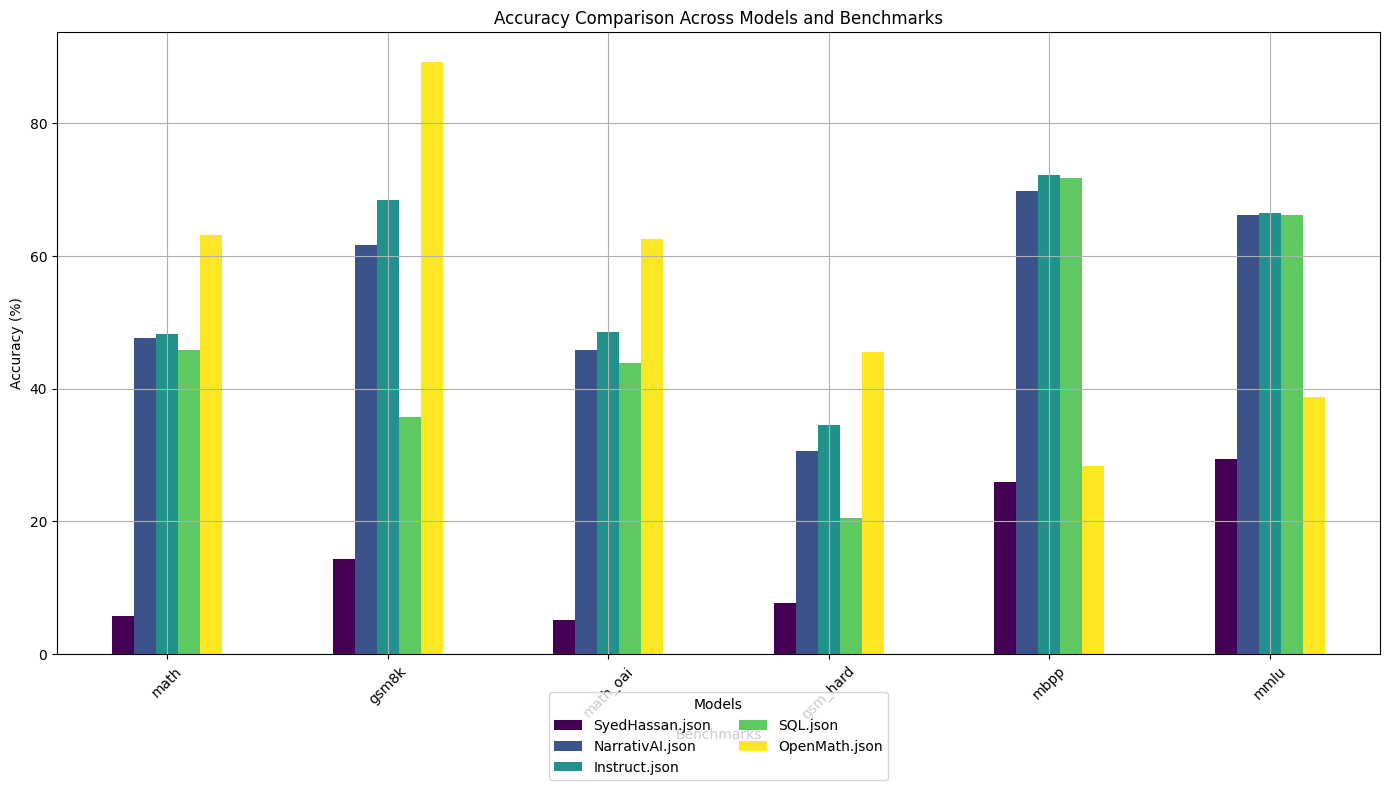

In [6]:

# Path to the directory containing JSON files
directory_path = "results/results_baseline"

# Load JSON files
json_data = load_json_files(directory_path)

# Plot overall accuracies
plot_accuracy(json_data)

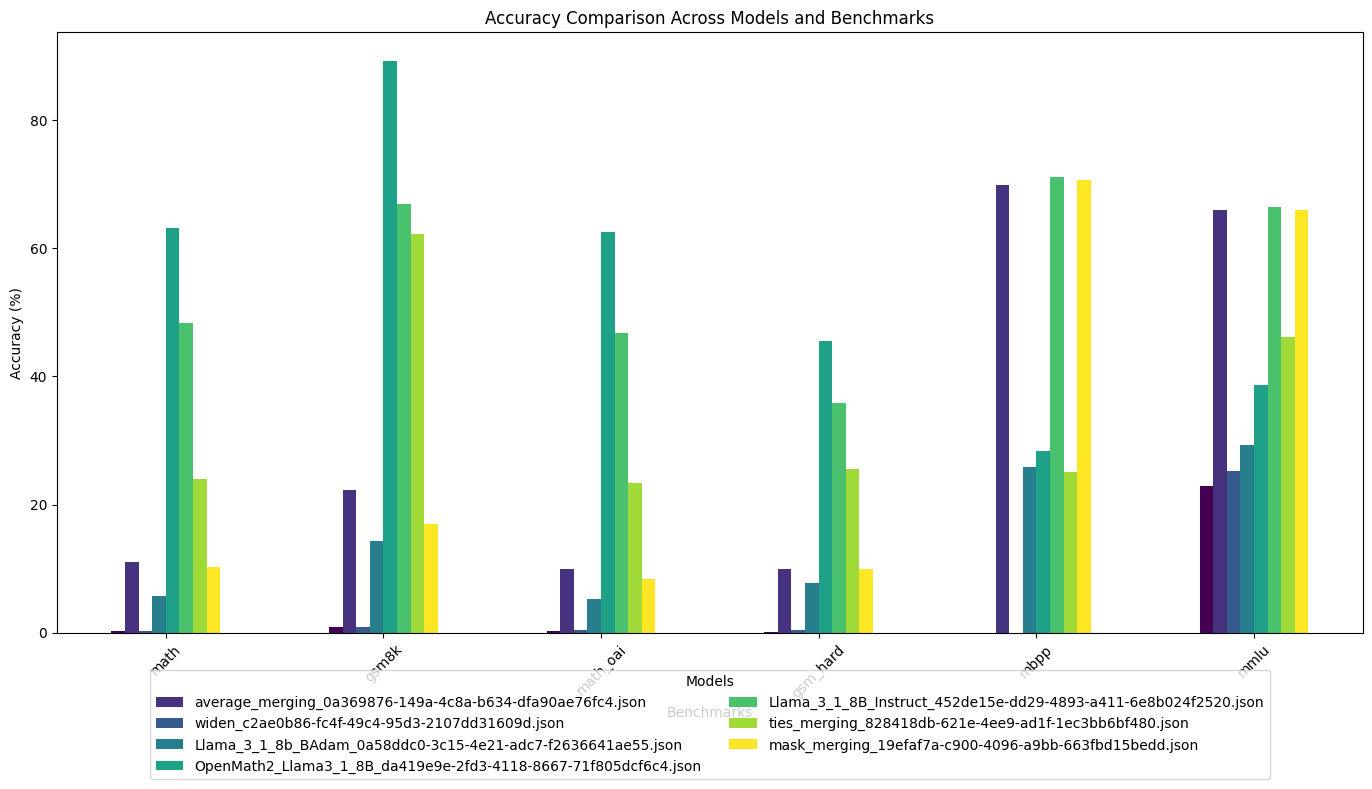

In [ ]:
# Path to the directory containing JSON files
directory_path = "results_"

# Load JSON files
json_data = load_json_files(directory_path)

# Plot overall accuracies
plot_accuracy(json_data)

In [ ]:
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer

MODEL_NAME = "markrodrigo/Llama-3.1-8B-Instruct-Spatial-SQL-1.0"
llm = LLM(model=MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [1]:
import argparse

import gradio as gr
from openai import OpenAI

# Argument parser setup
# parser = argparse.ArgumentParser(
#     description='Chatbot Interface with Customizable Parameters')
# parser.add_argument('--model-url',
#                     type=str,
#                     default='http://localhost:8000/v1',
#                     help='Model URL')
# parser.add_argument('-m',
#                     '--model',
#                     type=str,
#                     required=True,
#                     help='Model name for the chatbot')
# parser.add_argument('--temp',
#                     type=float,
#                     default=0.8,
#                     help='Temperature for text generation')
# parser.add_argument('--stop-token-ids',
#                     type=str,
#                     default='',
#                     help='Comma-separated stop token IDs')
# parser.add_argument("--host", type=str, default=None)
# parser.add_argument("--port", type=int, default=8001)

# # Parse the arguments
# args = parser.parse_args()

# Set OpenAI's API key and API base to use vLLM's API server.
openai_api_key = "EMPTY"
openai_api_base = "http://localhost:8000/v1"

# Create an OpenAI client to interact with the API server
client = OpenAI(
    api_key=openai_api_key,
    base_url=openai_api_base,
)


def predict(message, history):
    # Convert chat history to OpenAI format
    history_openai_format = [{
        "role": "system",
        "content": "You are a great ai assistant."
    }]
    for human, assistant in history:
        history_openai_format.append({"role": "user", "content": human})
        history_openai_format.append({
            "role": "assistant",
            "content": assistant
        })
    history_openai_format.append({"role": "user", "content": message})

    # Create a chat completion request and send it to the API server
    stream = client.chat.completions.create(
        model="markrodrigo/Llama-3.1-8B-Instruct-Spatial-SQL-1.0",  # Model name to use
        messages=history_openai_format,  # Chat history
        temperature=0.1,  # Temperature for text generation
        stream=True,  # Stream response
        extra_body={
            'repetition_penalty':
            1,
            'stop_token_ids': [
                int(id.strip()) for id in "".split(',')
                if id.strip()
            ] if None else []
        })

    # Read and return generated text from response stream
    partial_message = ""
    for chunk in stream:
        partial_message += (chunk.choices[0].delta.content or "")
        yield partial_message


# Create and launch a chat interface with Gradio
gr.ChatInterface(predict).queue().launch(share=True)

/home/amin/miniforge3/envs/VLLM/lib/python3.10/site-packages/gradio/components/chatbot.py:243: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://c169dd147bfe2aa163.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
